# MNIST Data Set

In [2]:
# load in the data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', as_frame=False)

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
# mnist is a dictionary, need to load in data and target
X, y = mnist.data, mnist.target
X.shape

(70000, 784)

784 features. And 70000 images.

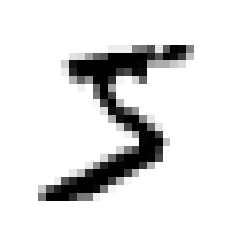

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

plot_digit(X[0])

In [6]:
y[0]

'5'

Labels are strings. Convert to ints.

In [7]:
y = y.astype(int)

Explore the first 100 images.

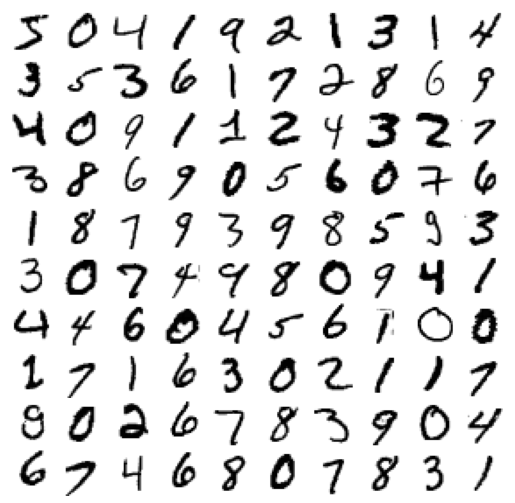

In [8]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(X[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)
plt.subplots_adjust(wspace=0, hspace=0)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5)

### A Simple Binary Classifier
- A binary classifier to determine if a particular number is 2 or not

In [10]:
y_train_2 = (y_train == 2)
y_test_2 = (y_test == 2)

- Use a Stochastic Gradient Descent (SGD) classifier, `SGDClassifier`
- `SGDClassifier` can handle large datasets efficiently since SGD deals with training instances independently

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()
%timeit
sgd_clf.fit(X_train, y_train_2)

SGDClassifier()

In [12]:
predictions = sgd_clf.predict(X_test)

In [13]:
from sklearn.model_selection import cross_val_score
# cv=5, Default of 5-fold cross validation
cross_val_score(sgd_clf, X_train, y_train_2, scoring="accuracy")

array([0.975     , 0.97042857, 0.96828571, 0.95657143, 0.976     ])

- Over 96% accuracy for a simple binary classifier
- Need to be skeptical about this results
- How many instances of a digit are in the dataset?

In [15]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 3504],
       [   1, 3919],
       [   2, 3478],
       [   3, 3583],
       [   4, 3317],
       [   5, 3147],
       [   6, 3464],
       [   7, 3688],
       [   8, 3453],
       [   9, 3447]])

- Each digit accounts for about 10% of the images
- A binary classifier should always have approximately 90% accuracy
- Build classifier using `BaseEstimator` to classify everything as not 2

In [16]:
from sklearn.base import BaseEstimator

class Not2Classifier(BaseEstimator): 
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
not_2_clf = Not2Classifier()
cross_val_score(not_2_clf, X_train, y_train_2, scoring="accuracy")

array([0.89857143, 0.90257143, 0.89442857, 0.90242857, 0.90514286])

- Approximately 90% accuracy...
- Accuracy is not a preferred performance metric for classifiers
- Compute the confusion matrix
- Similar to `cross_val_score()`, `cross_val_predict` performs K-fold cross validation
- Instead of returning evaluation score, predictions made on each test fold is returned
- Predictions are therefore made by the model on instances not seen during the training
- Use `confusion_matrix()`

In [18]:
from sklearn.model_selection import cross_val_predict
predictions = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_train_2, predictions)
conf_matrix

array([[31162,   360],
       [  797,  2681]])

In [20]:
print('True Negatives:', conf_matrix[0,0], '(correctly classified as non-2s)')
print('False Positives:', conf_matrix[0,1], '(wrongly classified as 2s)')
print('False Negatives:', conf_matrix[1,0], '(wrongly classified as non-2s)')
print('True Positives:', conf_matrix[1,1], '(correctly classified as 2s)')

True Negatives: 31162 (correctly classified as non-2s)
False Positives: 360 (wrongly classified as 2s)
False Negatives: 797 (wrongly classified as non-2s)
True Positives: 2681 (correctly classified as 2s)


A perfect classifier would have only true positives and true negatives (zeros on the main diagonal).

Precision of the classifier:

$$\mathrm{precision} = \frac{TP}{TP + FP}$$

TP is number of true positives and FP is number of false positives.

The ratio of positive instances that are correctly determined by the classifier, recall:

$$\mathrm{recall} = \frac{TP}{TP + FN}$$

FN is number of false negatives

In [21]:
from sklearn.metrics import precision_score, recall_score
print('Precision:', precision_score(y_train_2, predictions))
print('Recall:', recall_score(y_train_2, predictions))

Precision: 0.8816178888523512
Recall: 0.7708453133985049


Precision and recall can be combined together to create a F1 score.

In [22]:
from sklearn.metrics import f1_score
print('F1:', f1_score(y_train_2, predictions))

F1: 0.8225187912256481


F1 score favors classifiers that have similar precision and recall

### Precision/Recall Tradeoff
- Increasing precision reduces recall, and vice versa. This is called the precision/recall tradeoff
- For each instance it computes a score based on a decision function, and if that score is greater than a threshold, it assigns the instance to a positive class
- Using the `decision_function()`, return the score for each instance

In [ ]:
y_scores = sgd_clf.decision_function(X[0]

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_2, cv=3,
                                 method="decision_function")

With the scores, compute precision and recall for all possible thresholds using `precision_recall_curve()`.

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_2, y_scores)

Plot precision and recall as functions of the threshold.

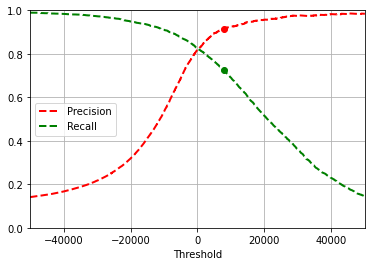

In [25]:
plt.plot(thresholds, precisions[:-1], 'r--', label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], 'g--', label='Recall', linewidth=2)

threshold=8000
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], 'ro')
plt.plot(thresholds[idx], recalls[idx], 'go')
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel('Threshold')
plt.legend(loc='best')

Plotting the precision against recall can help select a good precision/recall tradeoff.

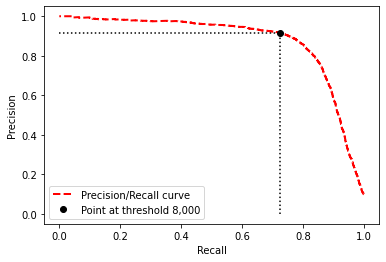

In [26]:
plt.plot(recalls, precisions, 'r--', linewidth=2, label='Precision/Recall curve')
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], 'k:')
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], 'k:')
plt.plot([recalls[idx]], [precisions[idx]], 'ko',
         label='Point at threshold 8,000')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')

- Create a classifier with 95% precision
- Search for the lowest threshold that gives 90% precision

In [27]:
# np.argmax() will give us the first index of the maximum value, which in this case means the first True value
threshold_precision_95 = thresholds[np.argmax(precisions >= 0.95)]

In [28]:
y_train_pred_95 = (y_scores >= threshold_precision_95)

In [29]:
print('Precision Score:', precision_score(y_train_2, y_train_pred_95))
print('Recall Score:', recall_score(y_train_2, y_train_pred_95))

Precision Score: 0.950381679389313
Recall Score: 0.5727429557216791


### ROC Curve

- The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers
- Instead of plotting precision against recall, ROC curve plots true positive rate (i.e. recall) against false positive rate
- The ROC curve plots sensitivity (i.e. recall) against 1-specificity
- Plot the ROC curve

In [30]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_2, y_scores)

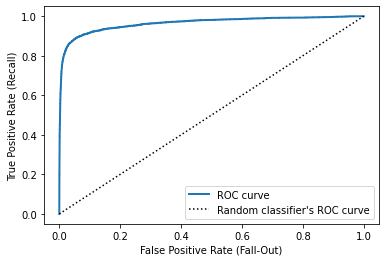

In [31]:
# plot fpr against tpr
plt.plot(fpr, tpr, linewidth=2, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.legend(loc='best')

- Higher the recall (TPR), the more false positives (FPR)
- Black dotted line is random classifier (poor)
- To compare classifiers, compute the area under the curve (AUC)

In [32]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_2, predictions)

0.8797123591293013

- Build `RandomForestClassifier` and compare ROC curves
- `RandomForestClassifier` does not have a `decision_function()` method, use `predict_proba()` method instead

In [33]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_clf,
                                    X_train,
                                    y_train_2,
                                    cv=3,
                                    method='predict_proba')

To plot ROC curve, use positive class' probability as the score.

In [34]:
y_probas_forest[:,1]

array([0.92, 0.02, 0.01, ..., 0.12, 0.03, 0.99])

In [35]:
# probability of a positive class
y_scores_forest = y_probas_forest[:,1]
pr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_2,y_scores_forest) # for plotting the curve

Compare ROC AUC Scores

In [36]:
print('Binary clf:', roc_auc_score(y_train_2, predictions))
print('Forest clf:', roc_auc_score(y_train_2, y_scores_forest))

Binary clf: 0.8797123591293013
Forest clf: 0.9969511558855778


# One-versus-all or One-verses-one

- OvA - train 10 binary classifiers, one for each didgit in MNIST
- OvO - train binary classifier for every pair of digits, N * (N-1) / 2 classifiers (for MNIST, that's 45 binary classifiers)
- OvO has one advantage, each classifier only needs to be trained on the part of the training set for the two classes it needs to distinguish - works well with SVMs since they scale poorly with the size of the training set
- Scikit-Learn automatically uses OvA, except for SVM, which uses OvO

In [37]:
sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [47]:
sgd_clf.predict(X[42].reshape(1,-1))

array([7])

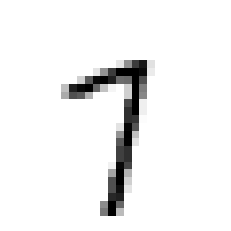

In [48]:
plot_digit(X[42])

Extract decision scores using the `decision_function()` method and use `np.argmax` to output the index of largest score, which should be `7`. The index into the classes with index `7` to return the digit `7`.

In [51]:
sgd_clf.decision_function(X[42].reshape(1, -1))

array([[-71236.65262098, -30682.81017145, -27964.36456457,
        -19625.8005959 , -22350.77283694,  -4819.81092523,
        -66789.40912616,   7878.70299704,  -7331.92329585,
          1087.99780183]])

In [52]:
np.argmax(sgd_clf.decision_function(X[42].reshape(1, -1)))

7

In [54]:
sgd_clf.classes_[np.argmax(sgd_clf.decision_function(X[42].reshape(1, -1)))]

7

`OneVsOneClassifier` with a `SGDClassifier` constructor.

In [57]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier())
ovo_clf.fit(X_train, y_train)
ovo_clf.predict(X[42].reshape(1, -1))

array([7])

In [58]:
print('Num. of estimators:', len(ovo_clf.estimators_))

Num. of estimators: 45


Train `RandomForestClassifier` with multioutput.

In [59]:
forest_clf.fit(X_train, y_train)
forest_clf.predict(X[42].reshape(1, -1))

array([7])

In [60]:
forest_clf.predict_proba([X[42]])

array([[0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.97, 0.  , 0.02]])

97% probability that `X[42]` is the 7th index in the array

Evaluate each model.

In [62]:
print('SDG CLF:', cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))
print('OvO CLF:', cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy"))
print('Forest CLF:', cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy"))

SDG CLF: [0.88231765 0.86131825 0.87527859]
OvO CLF: [0.91145967 0.91377389 0.91590948]
Forest CLF: [0.95714408 0.96082969 0.96039774]


Improve these scores by using scaling the inputs using `StandardScaler`.

In [63]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [66]:
print('Scaled SDG CLF:', cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))
print('Scaled OvO CLF:', cross_val_score(ovo_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))
print('Scaled Forest CLF:', cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:700: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


Scaled SDG CLF: [0.90108854 0.90674552 0.90288016]
Scaled OvO CLF: [0.91103111 0.9145453  0.91813818]
Scaled Forest CLF: [0.95860118 0.95954401 0.96168352]


By increasing `max_itter` the model can be improved (too computationally expensive). But its clear that the `RandomForestClassifier()` is the best.

Examine the feature importance using `RandomForestClassifier(n_estimators=100)`

In [67]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier()

In [69]:
model.feature_importances_.shape

(784,)

Turn it into a square matrix and call `sns.heatmap()`

In [70]:
feature_importance = model.feature_importances_.reshape(28,28)

<AxesSubplot:>

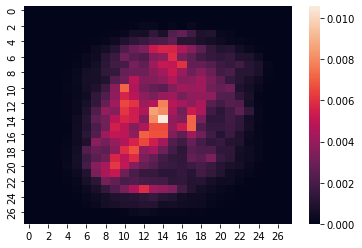

In [71]:
import seaborn as sns
sns.heatmap(feature_importance)

### AdaBoost (Adaptive Boosting)

- Boosting: Combining several weak learners into a strong learner
- Train predictors sequentially and correct the predecessor
- Relative weights of misclassified training instances are increased after training and the next classifier is trained on these updated weights...
- It is an ensemble, where each predictor/classifier/model has different weights depending on the overall accuracy of the training set

In [73]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# DecisionTreeClassifier is the default with max_dept=1 (require a 'weak' classifier)
# 200 estimators in total
# SAMME.R is the default algo - multiclass exponential loss function
model = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                          n_estimators=200,
                          algorithm='SAMME.R',
                          learning_rate=0.5)

In [74]:
model.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [75]:
cross_val_score(model, X_train, y_train, cv=3, scoring="accuracy")

array([0.62466787, 0.75794977, 0.66415224])

The `AdaBoostClassifier` is performing worse than `RandomForestClassifier`.

### XGBoost

- XGBoost in an optimized version of gradient boosting
- Instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor

In [81]:
import xgboost
# implement early stopping
model_xgb = xgboost.XGBRegressor(n_estimators=200, max_depth=10, learning_rate=0.1)
model_xgb.fit(X_train, y_train, 
             eval_set=[(X_train, y_train), (X_test, y_test)], 
             early_stopping_rounds=2)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-rmse:4.44057	validation_1-rmse:4.44428
[1]	validation_0-rmse:4.02691	validation_1-rmse:4.04241
[2]	validation_0-rmse:3.65554	validation_1-rmse:3.68400
[3]	validation_0-rmse:3.32074	validation_1-rmse:3.36406
[4]	validation_0-rmse:3.02094	validation_1-rmse:3.07883
[5]	validation_0-rmse:2.75101	validation_1-rmse:2.82320
[6]	validation_0-rmse:2.50566	validation_1-rmse:2.59508
[7]	validation_0-rmse:2.28706	validation_1-rmse:2.39351
[8]	validation_0-rmse:2.09126	validation_1-rmse:2.21601
[9]	validation_0-rmse:1.91347	validation_1-rmse:2.05737
[10]	validation_0-rmse:1.75360	validation_1-rmse:1.91691
[11]	validation_0-rmse:1.61036	validation_1-rmse:1.79369
[12]	validation_0-rmse:1.48321	validation_1-rmse:1.68627
[13]	validation_0-rmse:1.37017	validation_1-rmse:1.59303
[14]	validation_0-rmse:1.26663	validation_1-rmse:1.50996
[15]	validation_0-rmse:1.17566	validation_1-rmse:1.43807
[16]	validation_0-rmse:1.09234	validation_1-rmse:1.37336
[17]	validation_0-rmse:1.01957	validation

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=200, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Output the optimal number of trees.

In [84]:
model_xgb.best_ntree_limit

125

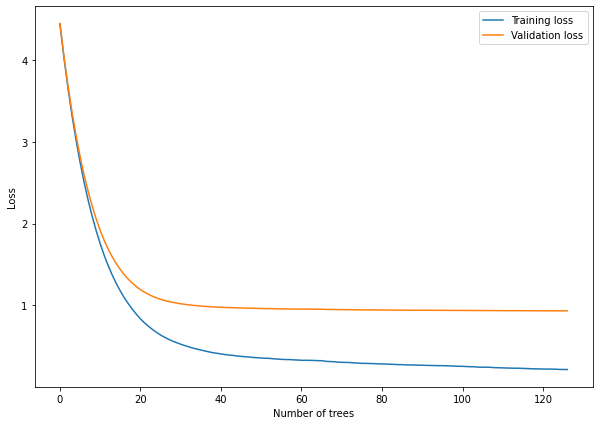

In [83]:
results = model_xgb.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results['validation_0']['rmse'], label='Training loss')
plt.plot(results['validation_1']['rmse'], label='Validation loss')
plt.xlabel('Number of trees')
plt.ylabel('Loss')
plt.legend()

- Could have continued training by increasing `early_stopping_rounds`
- Validation loss doesn't rise, which means model is not overfitting
- 125 seems to be the optimal number of trees
- Obviously this model can be improved with `GridSearchCV`

### Dimensionality Reduction with PCA

- Compute PCA without reducing dimensionality
- Compute minimum number of dimensions required to presever 95% of training set variance

In [91]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)

PCA(n_components=0.95)

In [92]:
pca.explained_variance_ratio_[:10]

array([0.09798911, 0.07130557, 0.06128029, 0.05383409, 0.04876647,
       0.0429063 , 0.03250898, 0.02883203, 0.02760191, 0.0235349 ])

In [93]:
X_pca_reduced = pca.fit_transform(X_train)

In [105]:
# forest classifier
model = RandomForestClassifier()
print('Reduced Forest CLF:', cross_val_score(model, X_pca_reduced, y_train, cv=3, scoring="accuracy"))

Reduced Forest CLF: [0.93211623 0.9311734  0.93811075]


### Compress images instead

In [97]:
pca = PCA(n_components=154)
X_pca_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_pca_reduced)

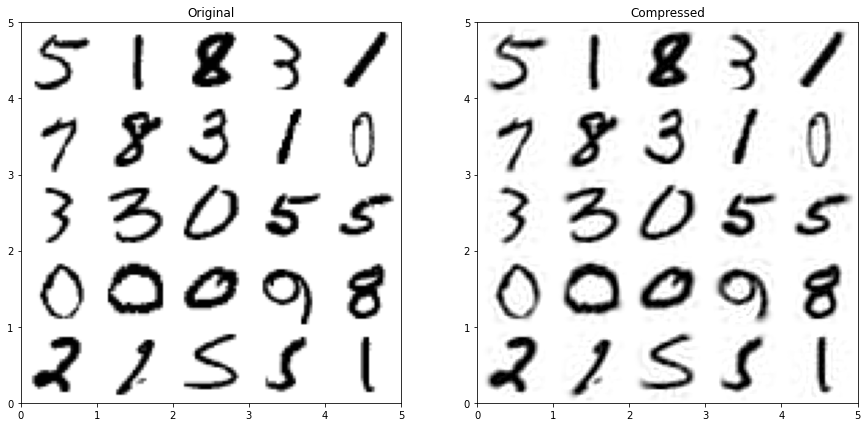

In [104]:
plt.figure(figsize=(15, 8))
for i, X in enumerate((X_train, X_recovered)):
    plt.subplot(1, 2, i + 1)
    plt.title(['Original', 'Compressed'][i])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])

In [107]:
# forest classifier
model = RandomForestClassifier()
print('Recovered Forest CLF:', cross_val_score(model, X_recovered, y_train, cv=3, scoring="accuracy"))

Recovered Forest CLF: [0.9536299  0.9544013  0.95679753]
